In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
START_DATE = "2021-01-01"
END_DATE = "2024-12-31"

# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"

In [3]:
df = pd.read_pickle(RESAMPLED_FILE_PATH)
df.head()

,timestamp,open,high,low,close,volume,spread
373333,2021-01-03 22:00:00,103.1185,103.1720,103.1175,103.1720,16990.000002,0.025600
373334,2021-01-03 22:01:00,103.1725,103.1740,103.1725,103.1740,4979.999989,0.025600
373335,2021-01-03 22:02:00,103.2150,103.2330,103.2150,103.2330,2369.999997,0.090000
373336,2021-01-03 22:03:00,103.2050,103.2075,103.1955,103.1955,6750.000000,0.041500
373337,2021-01-03 22:04:00,103.1965,103.2080,103.1965,103.2070,9740.000010,0.022857


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df = df.set_index('timestamp')

df.head()

,open,high,low,close,volume,spread
timestamp,,,,,,
2021-01-03 22:00:00,103.1185,103.1720,103.1175,103.1720,16990.000002,0.025600
2021-01-03 22:01:00,103.1725,103.1740,103.1725,103.1740,4979.999989,0.025600
2021-01-03 22:02:00,103.2150,103.2330,103.2150,103.2330,2369.999997,0.090000
2021-01-03 22:03:00,103.2050,103.2075,103.1955,103.1955,6750.000000,0.041500
2021-01-03 22:04:00,103.1965,103.2080,103.1965,103.2070,9740.000010,0.022857


## Datetime conversion

Dukascopy use UTC timezone

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

df

## Data Exloration

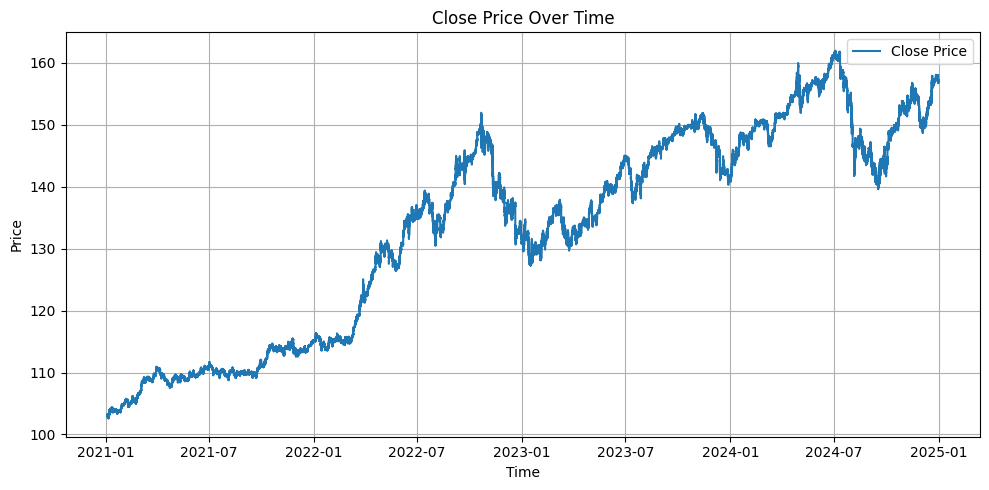

In [5]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close'], label='Close Price')

plt.title('Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


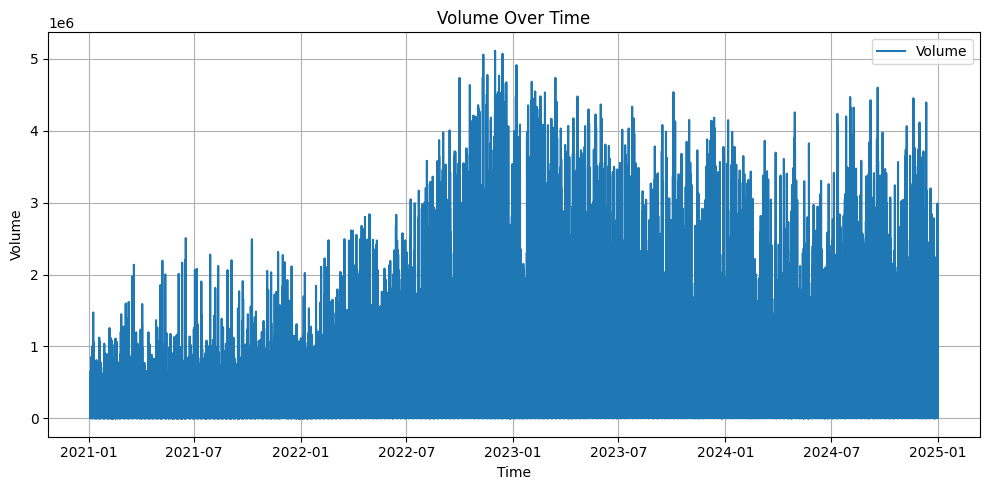

In [6]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['volume'], label='Volume')

plt.title('Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
df.isna().sum() / df.shape[0]

open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
spread    0.0
dtype: float64

# Volume Feature Engineering

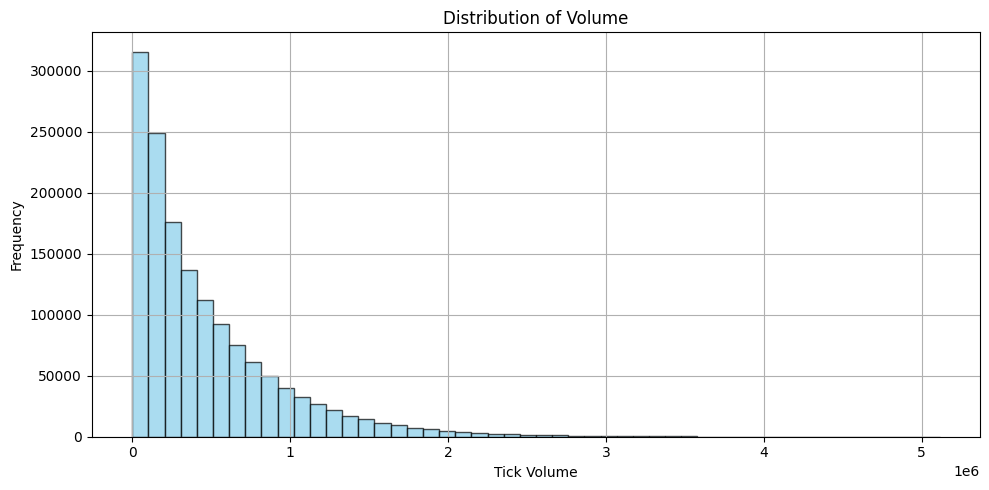

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Tick Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
df['log_volume'] = np.log1p(df['volume'])

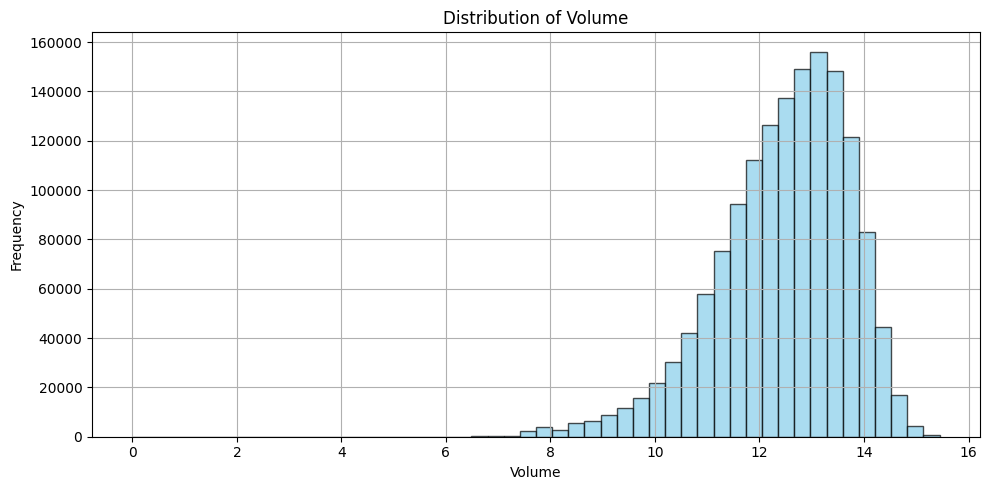

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['log_volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature engineering

## Add delta and return

The original price data is non-stationary, we can convert it into stationary data by calculating the difference between each timeframe as *delta* value.
And we are also adding *return* values that indicates the percentage of grow/drop from the last timeframe.
We will do the following process:
1. calculate delta and returns within each timegroup, note that this will result in adding 1 NaN value for each time group and will be dropped later on.
2. labeling the moving **direction** for each row based on the **return** and a given **threshold**
    ```
    'up' if x > threshold else ('down' if x < -threshold else 'flat')
    ```
3. use a global encoder to encode the **direction**, this column will later on be used as target to train our model.

In [11]:
import pandas as pd
import numpy as np

def add_return_features(df: pd.DataFrame, price_col: str = 'close') -> pd.DataFrame:
    """
    Adds delta, simple return, and log return columns based on a single price column.

    Args:
        df (pd.DataFrame): Input DataFrame with a price column.
        price_col (str): Column name containing price values (default = 'close').

    Returns:
        pd.DataFrame: DataFrame with added columns:
            - {price_col}_delta
            - {price_col}_return
            - {price_col}_log_return
    """
    df = df.copy()
    df[f"{price_col}_delta"] = df[price_col] - df[price_col].shift(1)
    df[f"{price_col}_return"] = df[price_col] / df[price_col].shift(1) - 1
    df[f"{price_col}_log_return"] = np.log(df[price_col] / df[price_col].shift(1))

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df


In [12]:
df = add_return_features(df)

## Plot histgram

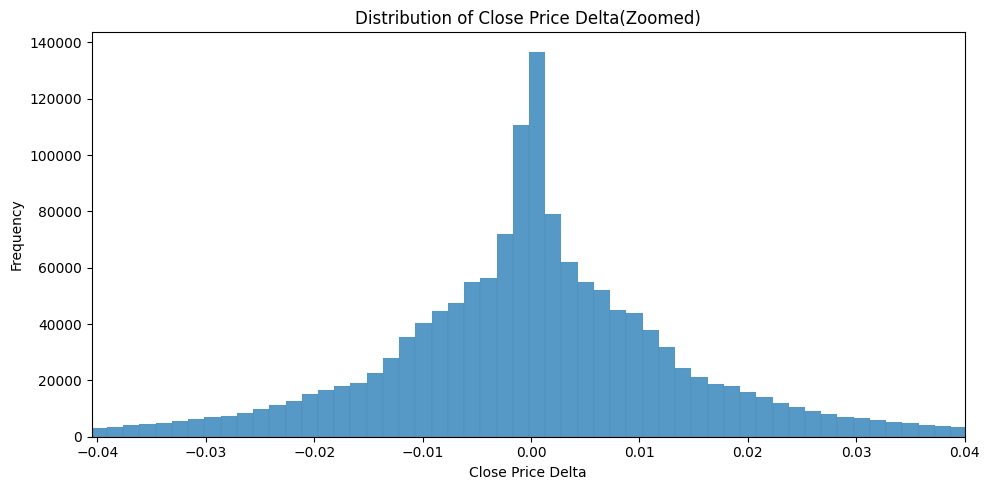

In [13]:
import seaborn as sns

df_copy = df.copy()

low, high = df_copy['close_delta'].quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_delta'])
plt.title("Distribution of Close Price Delta(Zoomed)")
plt.xlabel("Close Price Delta")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

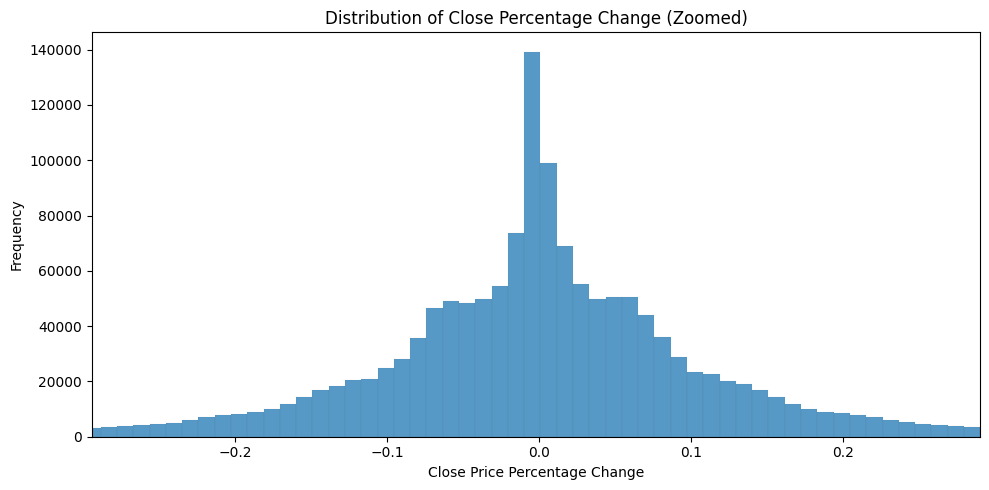

In [14]:
df_copy = df.copy()

low, high = (df_copy['close_return']*1000).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_return']*1000)
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

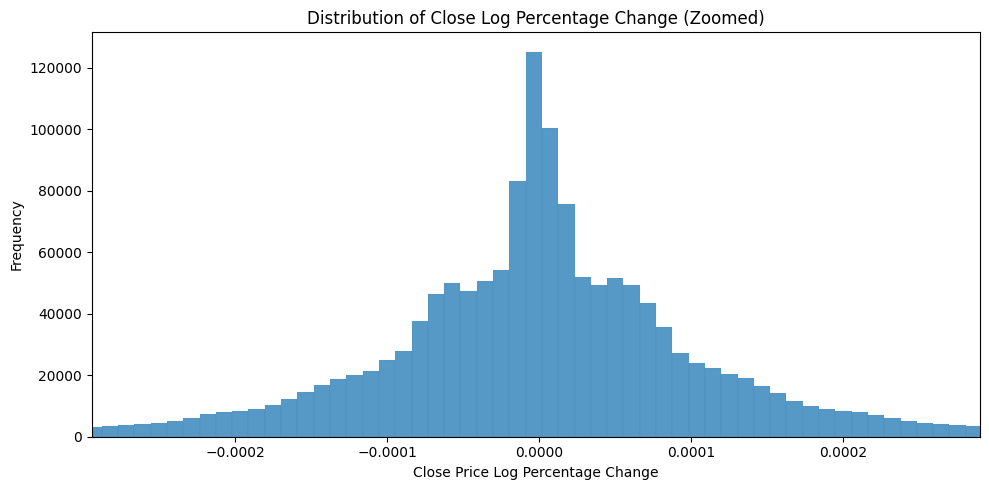

In [15]:
df_copy = df.copy()

low, high = (df_copy['close_log_return']).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_log_return'])
plt.title("Distribution of Close Log Percentage Change (Zoomed)")
plt.xlabel("Close Price Log Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

## Calculate average values

df['ma_21'] = (
    df['close']
    .rolling(window=21, min_periods=1)
    .mean()
)
df.head()

In [16]:
df['ret_mean_5'] = (
    df['close_log_return']
    .rolling(window=5, min_periods=5)
    .mean()
)
df.head()

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5
timestamp,,,,,,,,,,,
2021-01-03 22:00:00,103.1185,103.1720,103.1175,103.1720,16990.000002,0.025600,9.740439,NaN,NaN,NaN,NaN
2021-01-03 22:01:00,103.1725,103.1740,103.1725,103.1740,4979.999989,0.025600,8.513386,0.0020,0.000019,0.000019,NaN
2021-01-03 22:02:00,103.2150,103.2330,103.2150,103.2330,2369.999997,0.090000,7.771067,0.0590,0.000572,0.000572,NaN
2021-01-03 22:03:00,103.2050,103.2075,103.1955,103.1955,6750.000000,0.041500,8.817446,-0.0375,-0.000363,-0.000363,NaN
2021-01-03 22:04:00,103.1965,103.2080,103.1965,103.2070,9740.000010,0.022857,9.184099,0.0115,0.000111,0.000111,NaN


In [17]:
df['ret_mean_10'] = (
    df['close_log_return']
    .rolling(window=10, min_periods=10)
    .mean()
)
df.head()

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10
timestamp,,,,,,,,,,,,
2021-01-03 22:00:00,103.1185,103.1720,103.1175,103.1720,16990.000002,0.025600,9.740439,NaN,NaN,NaN,NaN,NaN
2021-01-03 22:01:00,103.1725,103.1740,103.1725,103.1740,4979.999989,0.025600,8.513386,0.0020,0.000019,0.000019,NaN,NaN
2021-01-03 22:02:00,103.2150,103.2330,103.2150,103.2330,2369.999997,0.090000,7.771067,0.0590,0.000572,0.000572,NaN,NaN
2021-01-03 22:03:00,103.2050,103.2075,103.1955,103.1955,6750.000000,0.041500,8.817446,-0.0375,-0.000363,-0.000363,NaN,NaN
2021-01-03 22:04:00,103.1965,103.2080,103.1965,103.2070,9740.000010,0.022857,9.184099,0.0115,0.000111,0.000111,NaN,NaN


## Drop NaN

In [18]:
df.isna().sum()

open                 0
high                 0
low                  0
close                0
volume               0
spread               0
log_volume           0
close_delta          1
close_return         1
close_log_return     1
ret_mean_5           5
ret_mean_10         10
dtype: int64

In [19]:
df = df.dropna()

In [20]:
df

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10
timestamp,,,,,,,,,,,,
2021-01-03 22:10:00,103.2270,103.2355,103.2270,103.2270,6870.000005,0.023000,8.835065,0.0045,0.000044,0.000044,3.197094e-05,0.000053
2021-01-03 22:11:00,103.2270,103.2280,103.2270,103.2280,7900.000095,0.028667,8.974745,0.0010,0.000010,0.000010,3.874955e-06,0.000052
2021-01-03 22:12:00,103.2280,103.2280,103.2255,103.2255,8750.000000,0.027250,9.076923,-0.0025,-0.000024,-0.000024,5.812602e-06,-0.000007
2021-01-03 22:13:00,103.2275,103.2275,103.2275,103.2275,2000.000000,0.029000,7.601402,0.0020,0.000019,0.000019,-9.687318e-07,0.000031
2021-01-03 22:14:00,103.2280,103.2280,103.2280,103.2280,2000.000000,0.030000,7.601402,0.0005,0.000005,0.000005,1.065631e-05,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:55:00,157.0100,157.0110,157.0075,157.0080,206939.997196,0.011818,12.240189,-0.0045,-0.000029,-0.000029,1.656035e-05,-0.000016
2024-12-30 23:56:00,157.0075,157.0090,157.0075,157.0075,127200.000405,0.010920,11.753524,-0.0005,-0.000003,-0.000003,1.337560e-05,0.000008
2024-12-30 23:57:00,157.0035,157.0095,156.9900,157.0070,234090.000987,0.007978,12.363465,-0.0005,-0.000003,-0.000003,1.210174e-05,0.000014


# Saving the file

In [21]:
df.to_pickle(PROCESSED_FILE_PATH)